In [1]:
import scipy.io as sio
import scipy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import time
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from tensorflow.contrib.slim import fully_connected as fc
from tensorflow.python.ops.parallel_for.gradients import jacobian



import random

In [2]:
train = sio.loadmat('train.mat')
test = sio.loadmat('test.mat')
test30 = sio.loadmat('test30.mat')
G = sio.loadmat('G.mat')
w = 100
h = 100
train = np.array(train["train"]).transpose()
test = np.array(test["test"]).transpose()
test30 = np.array(test30["test30"]).transpose()
G = np.array(G["G"]).transpose()
input_dim = w*h
num_sample = 2400
totals = 6
maxiter = 4
kpers = 6
totalk = totals*kpers
train[train<4] = 0
train[train>4] = 1
test[test<4] = 0
test[test>4] = 1
test30[test30<4] = 0
test30[test30>4] = 1
PHI = np.zeros((totalk,10000))
print(train.shape)
print(test.shape)
print(G.shape)

(2400, 10000)
(600, 10000)
(10000, 50)


In [3]:
def viz_grid0(Xs, ubound=255.0, padding=1):
    N, H, W, C = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid
def viz_grid(Xs, padding,pad_value):
    N, H, W, C = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size + 1)
    grid_width = W * grid_size + padding * (grid_size + 1)
    grid = np.ones((grid_height, grid_width, C))*pad_value
    next_idx = 0
    y0, y1 = padding, H + padding
    for y in range(grid_size):
        x0, x1 = padding, W + padding
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid
def viz_grid2(Xs, padding,pad_value):
    N, H, W = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size + 1)
    grid_width = W * grid_size + padding * (grid_size + 1)
    grid = np.ones((grid_height, grid_width))*pad_value
    next_idx = 0
    y0, y1 = padding, H + padding
    for y in range(grid_size):
        x0, x1 = padding, W + padding
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid
def viz_grid3(Xs, padding, gh, gw,pad_value):
    
    N, H, W = Xs.shape
    #grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * gh + padding * (gh + 1)
    grid_width = W * gw + padding * (gw + 1)
    
    
    grid = np.ones((grid_height, grid_width))*pad_value
    next_idx = 0
    y0, y1 = padding, H + padding
    for y in range(gh):
        x0, x1 = padding, W + padding
        for x in range(gw):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

def plotfigureswithbar(x,nrows,ncols,vmi,vma):    
    fig, axes = plt.subplots(nrows, ncols,figsize = (ncols*2, nrows*2))
    axesf = axes.flatten()
    for i in range(ncols*nrows):

        ax1 = axesf[i]
        ax1.imshow(x[i].reshape(100,100),cmap='gray_r',vmin=vmi, vmax=vma)


        ax1.axes.get_xaxis().set_visible(False)
        ax1.axes.get_yaxis().set_visible(False)
    cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
    cb = mpl.colorbar.ColorbarBase(cax, cmap='gray_r', norm = mpl.colors.Normalize(vmin=0, vmax=1),spacing='proportional')
def plotfigures(x,nrows,ncols,vmi,vma):  
    fig, axes = plt.subplots(nrows, ncols,figsize = (ncols*2, nrows*2))
    axesf = axes.flatten()
    for i in range(ncols*nrows):

        ax1 = axesf[i]
        ax1.imshow(x[i].reshape(100,100),cmap='gray_r',vmin=vmi, vmax=vma)
        #ax1.imshow(x[i].reshape(100,100),cmap='gray_r')

        ax1.axes.get_xaxis().set_visible(False)
        ax1.axes.get_yaxis().set_visible(False)
def plotfigures2(x,nrows,ncols):  
    fig, axes = plt.subplots(nrows, ncols,figsize = (ncols*2, nrows*2))
    axesf = axes.flatten()
    for i in range(ncols*nrows):

        ax1 = axesf[i]
        ax1.imshow(x[i].reshape(100,100),cmap='gray_r')
        #ax1.imshow(x[i].reshape(100,100),cmap='gray_r')

        ax1.axes.get_xaxis().set_visible(False)
        ax1.axes.get_yaxis().set_visible(False)
def plotfigures3(x,nrows,ncols,ra):  
    fig, axes = plt.subplots(nrows, ncols,figsize = (ncols*ra, nrows*ra))
    axesf = axes.flatten()
    for i in range(ncols*nrows):

        ax1 = axesf[i]
        ax1.imshow(x[i].reshape(100,100),cmap='gray_r')
        #ax1.imshow(x[i].reshape(100,100),cmap='gray_r')

        ax1.axes.get_xaxis().set_visible(False)
        ax1.axes.get_yaxis().set_visible(False)

In [1]:
class VAE8(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=35,l2c = 0):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z
        self.l2c = l2c
        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    def build(self):
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])
        self.learning_rate = tf.placeholder(name = 'learning_rate',dtype = tf.float64,shape = None)
        self.is_training = tf.placeholder(name = 'is_training',dtype = tf.bool,shape = None)
        inp = tf.reshape(self.x,[-1,40,120,40,1])
        conv1 = tf.contrib.layers.conv2d(inp,8,[3,3],stride=2,
                                 padding='SAME',activation_fn=tf.nn.relu, scope = 'conv1')
        conv2 = tf.contrib.layers.conv2d(conv1,16,[3,3],stride=2,
                                 padding='SAME',activation_fn=tf.nn.relu, scope = 'conv2')
        conv3 = tf.contrib.layers.conv2d(conv2,32,[3,3],stride=2,
                                 padding='VALID',activation_fn=tf.nn.relu, scope = 'conv3')
        conv4 = tf.contrib.layers.conv2d(conv3,64,[3,3],stride=2,
                                 padding='SAME',activation_fn=tf.nn.relu, scope = 'conv4')
        conv5 = tf.contrib.layers.conv2d(conv4,128,[3,3],stride=2,
                                 padding='SAME',activation_fn=tf.nn.relu, scope = 'conv5')
        f0 = tf.reshape(conv5,[-1,3*3*128])
        
        self.z_mu = fc(f0, self.n_z, scope='enc_mu', 
                       activation_fn=None)
        self.z_log_sigma_sq = fc(f0, self.n_z, scope='enc_sigma', 
                                 activation_fn=None)
        eps = tf.random_normal(
            shape=tf.shape(self.z_log_sigma_sq),
            mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        dfc1 = fc(self.z, 3*3*128, scope='dfc1',activation_fn=tf.nn.relu)
        inp = tf.reshape(dfc1,[-1,3,3,128])
        dconv0 = tf.layers.conv2d_transpose(inp,64,3,2,"SAME",activation=tf.nn.relu, name= 'dconv0')
        dconv1 = tf.layers.conv2d_transpose(dconv0,32,3,2,"SAME",activation=tf.nn.relu, name= 'dconv1')
        print(dconv1.shape)
        
        dconv2 = tf.layers.conv2d_transpose(dconv1,16,3,2,"VALID", activation=tf.nn.relu, name = 'dconv2')
        print(dconv2.shape)
        
        
        dconv3 = tf.layers.conv2d_transpose(dconv2,8,3,2,"SAME",  activation=tf.nn.relu, name = 'dconv3')
        print(dconv3.shape)
        
        dconv4 = tf.layers.conv2d_transpose(dconv3,1,3,2,"SAME",activation=tf.nn.sigmoid, name = 'dconv4')
        print(dconv3.shape)
        
        self.x_hat = tf.reshape(dconv4,[-1,dconv4.shape[2]*dconv4.shape[1]])
        epsilon = 1e-5
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        
        self.recon_loss = tf.reduce_mean(recon_loss)
        self.l2w = sum(tf.nn.l2_loss(var) for var in tf.trainable_variables() if not 'biases' in var.name)
        self.l2b = sum(tf.nn.l2_loss(var) for var in tf.trainable_variables() if not 'weights' in var.name)
        # Latent loss
        # KL divergence: measure the difference between two distributions
        # Here we measure the divergence between 
        # the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - 
            tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = self.n_z*tf.reduce_mean(latent_loss)

        self.total_loss = self.recon_loss + 3*self.latent_loss + self.l2c*(self.l2w+self.l2b)
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
            'l2': self.l2w
        }        
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x,learning_rate):
        is_training = True
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x, self.learning_rate:learning_rate,self.is_training : is_training}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        is_training = False
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x,self.is_training : is_training})
        return x_hat

    # z -> x
    def generator(self, z):
        is_training = False
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z,self.is_training : is_training})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        is_training = False
        z = self.sess.run(self.z, feed_dict={self.x: x,self.is_training : is_training})
        return z
    def caljacob(self,z):
        is_training = False
        jacob = self.sess.run(jacobian(self.x_hat,self.z), feed_dict={self.z:z,self.is_training : is_training})
        return jacob

In [2]:
def test_reconstruction(model, test,h=100, w=100, batch_size=30):

  x_pcarecon = model.reconstructor(test)
  print(x_pcarecon[0])
  test = np.array(test)
  #sio.savemat("x_Vrecon",{"PCAVreconstruction":x_pcarecon})
  n = int(np.sqrt(batch_size))
  print(n)
  I_recon = np.empty(shape=(2*batch_size,h,w))
  print(I_recon.shape)
  for i in range(6):
        for j in range(5):
            I_recon[(2*i*n)+j] = test[(i*n)+j].reshape(h, w).transpose()
            I_recon[(2*i*n)+n+j] = x_pcarecon[(i*n)+j].reshape(h, w).transpose()
  print(I_recon.shape)
  fig = plt.figure(figsize = (20, 40))   
  ax1 = plt.subplot(111)
  ax1.imshow(viz_grid3(I_recon,5, 12,5,0.5).transpose(),cmap='gray_r')
    
  ax1.axes.get_xaxis().set_visible(False)
  ax1.axes.get_yaxis().set_visible(False)
  plt.show()

In [ ]:
def trainer(
    model_object, 
    learning_rate=1e-4, batch_size=64, 
    num_epochs=100, n_z=50, log_step=10,savename = "tf_models/VAE.ckpt",l2c = 0,train0 = train):
    model = model_object(
      learning_rate=learning_rate, 
      batch_size=batch_size,
      n_z=n_z,
      l2c = l2c
    )
    train = np.array(train0)
    for epoch in range(num_epochs):
        start_time = time.time()
        np.random.shuffle(train)
        for iter in range(num_sample // batch_size):
      # get a batch
            #print(batch.shape)
            batch = train[iter*batch_size:(iter+1)*batch_size]
      # execute the forward and backward path
      # report computed losses
      #print(batch.shape)
            losses = model.run_single_step(batch,learning_rate)
        end_time = time.time()
        if epoch % log_step == 0:
            log_str = '[Epoch: {}] '.format(epoch)
      #print(losses)
            for k, v in losses.items():
                log_str += '{}: {:.3f}'.format(k, v)
                log_str += '({:.3f}sec/epoch)'.format(end_time - start_time)
            print(log_str)
        if epoch % 50== 0:
            learning_rate = learning_rate*0.98
            test_reconstruction(model, test30)
    saver = tf.train.Saver()
    model_path = saver.save(model.sess, savename)
    test_reconstruction(model, test30)
    print("Model saved in %s" % model_path)
    print('Done')
    return model

In [ ]:
model = trainer(VAE8, num_epochs=500, learning_rate=1e-3, batch_size=100,l2c = 0.05,n_z=16,savename = "tf_models/slimmodels/VAE16.ckpt")

In [66]:
model = VAE8(n_z = 32)
saver = tf.train.Saver()
saver.restore(model.sess, "tf_models/slimmodels/VAE32.ckpt")

(?, 12, 12, 32)
(?, 25, 25, 16)
(?, 50, 50, 8)
(?, 50, 50, 8)
INFO:tensorflow:Restoring parameters from tf_models/slimmodels/VAE32.ckpt


In [108]:
a = model.transformer(test30[10:11])
jac = np.squeeze(model.caljacob(a))
print(jac.shape)

(10000, 16)


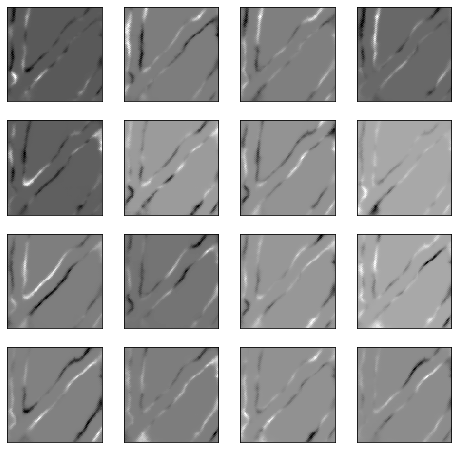

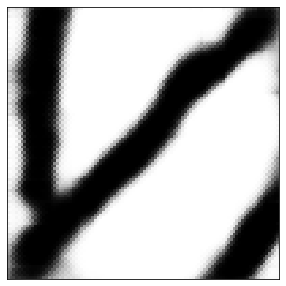

In [109]:
plotfigures2(jac.T,4,4)
fig = plt.figure(figsize = (5, 5),frameon=True)   
ax1 = plt.subplot(111)
ax1.imshow((model.generator(a)).reshape((100,100)),cmap='gray_r',vmin = 0,vmax = 1)
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
plt.show()

[0.72208506 0.7645995  0.85244966 ... 0.47019333 0.5243336  0.55712396]
5
(60, 100, 100)
(60, 100, 100)


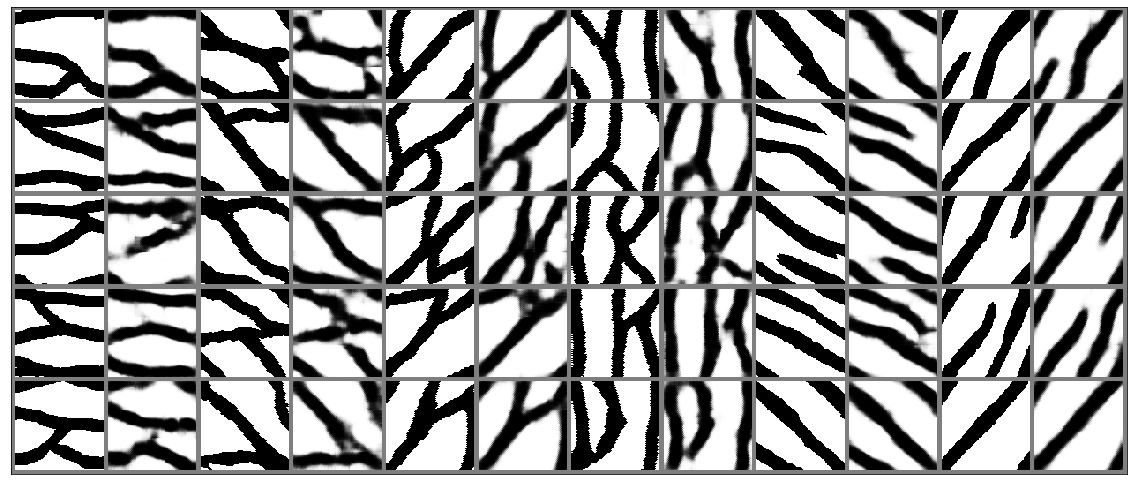

In [34]:
test_reconstruction(model, test30)

In [65]:
model.sess.close()

In [42]:
def test_generation(model,n,n_z):
    
    z = np.random.normal(size=[n**2,n_z])

    x_generated = model.generator(z)
    print(x_generated.shape)
    plotfigures(x_generated,n,n,0,1)
    mis = np.zeros((n**2,2400))
    for ind in range(2400):
        mis[:,ind] = np.linalg.norm(x_generated-train[ind,:],axis = 1)
    thei = np.argmin(mis,axis = 1)
    print(thei)
    close = train[thei,:]
    plotfigures(close,n,n,0,1)

(9, 10000)
[2149 1895 1603 1682 2228 1947 1442  342  713]


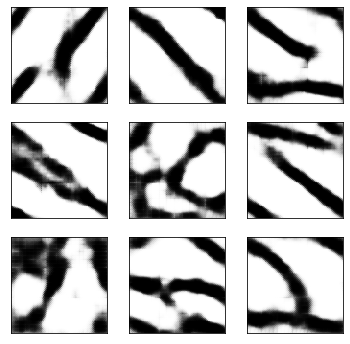

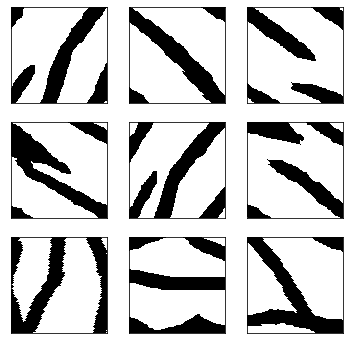

In [45]:
test_generation(model,3,16)

In [130]:
z = np.random.normal(size=[600,16])
x_generated = model.generator(z)
condip = np.zeros((600,5))
condip[:,0] = x_generated[:,909]
condip[:,1] = x_generated[:,989]
condip[:,2] = x_generated[:,4949]
condip[:,3] = x_generated[:,8909]
condip[:,4] = x_generated[:,8989]

Text(0, 0.5, 'Normalized Frequency')

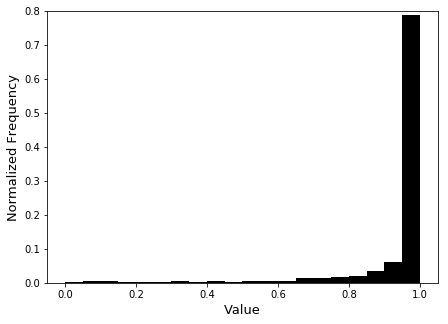

In [12]:
condipv = np.reshape(condip,(3000,1))
plt.figure(figsize = (7,5))
plt.hist(condipv, bins=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],color='k',weights=np.ones(len(condipv)) / len(condipv), density=False)
plt.ylim(0, 0.8)
plt.xlabel('Value',fontsize = 13)
plt.ylabel('Normalized Frequency',fontsize = 13)
#plt.title("Histogram of Values at Conditioned Points in Generated Realizations",fontsize = 13)

(600, 10000)


Text(0, 0.5, 'Normalized Frequency')

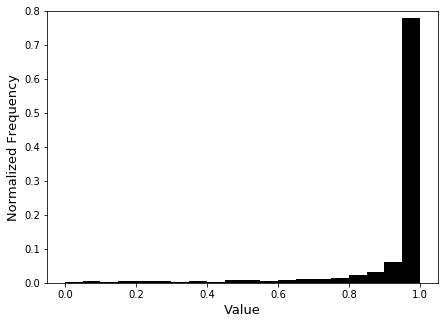

In [13]:
x_pcarecon = model.reconstructor(test)
print(x_pcarecon.shape)
condip = np.zeros((600,5))
condip[:,0] = x_pcarecon[:,909]
condip[:,1] = x_pcarecon[:,989]
condip[:,2] = x_pcarecon[:,4949]
condip[:,3] = x_pcarecon[:,8909]
condip[:,4] = x_pcarecon[:,8989]
condipv = np.reshape(condip,(3000,1))
plt.figure(figsize = (7,5))
plt.hist(condipv, bins=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],color='k',weights=np.ones(len(condipv)) / len(condipv), density=False)
plt.ylim(0, 0.8)
plt.xlabel('Value',fontsize = 13)
plt.ylabel('Normalized Frequency',fontsize = 13)
#plt.title("Histogram of Values at Conditioned Points in Reconstructions",fontsize = 13)

Text(0.5, 0, 'Z1')

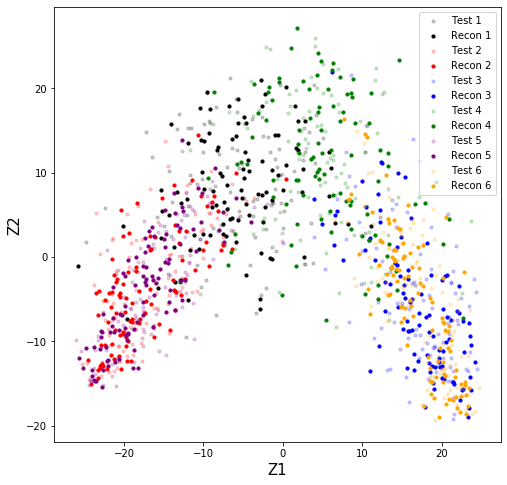

In [98]:
x_recon = model.reconstructor(test)
plt.figure(figsize=(8, 8))
z = (test+1-mean12)@(U12.T)
x = (x_recon+1-mean12)@(U12.T)
plt.scatter(z[:100, 0], z[:100, 1],marker = 'o',s=10,color = 'black',alpha = 0.2)
plt.scatter(x[:100, 0], x[:100, 1],s=10,color = 'black',alpha = 1)

plt.scatter(z[100:200, 0], z[100:200, 1],s=10,color = 'red',alpha = 0.2)
plt.scatter(x[100:200, 0], x[100:200, 1],s=10,color = 'red',alpha = 1)

plt.scatter(z[200:300, 0],z[200:300, 1],s=10,color = 'blue',alpha = 0.2)
plt.scatter(x[200:300, 0], x[200:300, 1],s=10,color = 'blue',alpha = 1)

plt.scatter(z[300:400, 0], z[300:400, 1],s=10,color = 'green',alpha = 0.2)
plt.scatter(x[300:400, 0], x[300:400, 1],s=10,color = 'green',alpha = 1)

plt.scatter(z[400:500, 0], z[400:500, 1],s=10,color = 'Purple',alpha = 0.2)
plt.scatter(x[400:500, 0], x[400:500, 1],s=10,color = 'Purple',alpha = 1)

plt.scatter(z[500:600, 0], z[500:600, 1],s=10,color = 'orange',alpha = 0.2)
plt.scatter(x[500:600, 0], x[500:600, 1],s=10,color = 'orange',alpha = 1)

plt.legend(['Test 1', 'Recon 1','Test 2', 'Recon 2','Test 3', 'Recon 3','Test 4', 'Recon 4','Test 5', 'Recon 5','Test 6', 'Recon 6',],loc = 1)
plt.ylabel('\u03A62',fontsize = 15)
plt.xlabel('\u03A61',fontsize = 15)


In [72]:
z = np.random.normal(size=[600,16])
x_recon = model.reconstructor(test)
x_generated = model.generator(z)
X_embedded = TSNE(n_components=2,init='pca', random_state=0).fit_transform(x_generated)

In [111]:
xtofit = np.zeros((4800,10000))
xtofit[:2400] = train
xtofit[2400:4800] = model.reconstructor(train)
X_embedded = TSNE(n_components=2,init='pca', random_state=0).fit_transform(xtofit)

Text(0.5, 0, 'Z1')

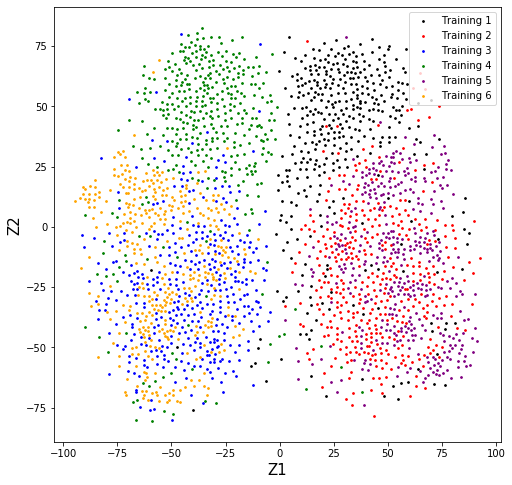

In [112]:
plt.figure(figsize=(8, 8))
plt.scatter(X_embedded[:400, 0], X_embedded[:400, 1],marker = 'o',s=3,color = 'black',alpha = 1)
#plt.scatter(X_embedded[2400:2800, 0], X_embedded[2400:2800, 1],s=3,color = 'black',alpha = 1)

plt.scatter(X_embedded[400:800, 0], X_embedded[400:800, 1],s=3,color = 'red',alpha = 1)
#plt.scatter(X_embedded[2800:3200, 0], X_embedded[2800:3200, 1],s=3,color = 'red',alpha = 1)

plt.scatter(X_embedded[800:1200, 0], X_embedded[800:1200, 1],s=3,color = 'blue',alpha = 1)
#plt.scatter(X_embedded[3200:3600, 0], X_embedded[3200:3600, 1],s=3,color = 'blue',alpha = 1)

plt.scatter(X_embedded[1200:1600, 0], X_embedded[1200:1600, 1],s=3,color = 'green',alpha = 1)
#plt.scatter(X_embedded[3600:4000, 0], X_embedded[3600:4000, 1],s=3,color = 'green',alpha = 1)

plt.scatter(X_embedded[1600:2000, 0], X_embedded[1600:2000, 1],s=3,color = 'Purple',alpha = 1)
#plt.scatter(X_embedded[4000:4400, 0], X_embedded[4000:4400, 1],s=3,color = 'Purple',alpha = 1)

plt.scatter(X_embedded[2000:2400, 0], X_embedded[2000:2400, 1],s=3,color = 'orange',alpha = 1)
#plt.scatter(X_embedded[4400:4800, 0], X_embedded[4400:4800, 1],s=3,color = 'orange',alpha = 1)

plt.legend(['Training 1','Training 2','Training 3','Training 4','Training 5','Training 6'],loc = 1)
plt.ylabel('Z2',fontsize = 15)
plt.xlabel('Z1',fontsize = 15)

Text(0.5, 0, 'Z1')

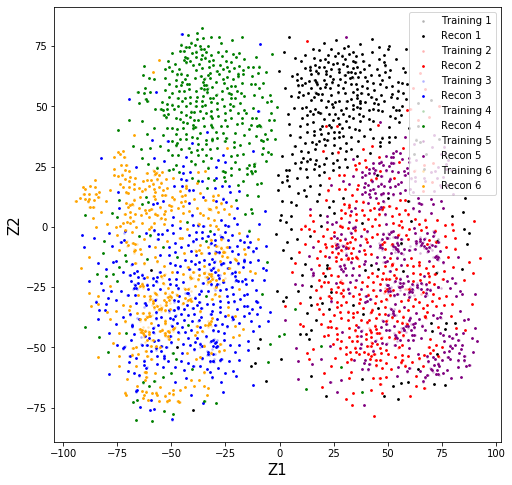

In [113]:
plt.figure(figsize=(8, 8))
plt.scatter(X_embedded[:400, 0], X_embedded[:400, 1],marker = 'o',s=3,color = 'black',alpha = 0.2)
plt.scatter(X_embedded[2400:2800, 0], X_embedded[2400:2800, 1],s=3,color = 'black',alpha = 1)

plt.scatter(X_embedded[400:800, 0], X_embedded[400:800, 1],s=3,color = 'red',alpha = 0.2)
plt.scatter(X_embedded[2800:3200, 0], X_embedded[2800:3200, 1],s=3,color = 'red',alpha = 1)

plt.scatter(X_embedded[800:1200, 0], X_embedded[800:1200, 1],s=3,color = 'blue',alpha = 0.2)
plt.scatter(X_embedded[3200:3600, 0], X_embedded[3200:3600, 1],s=3,color = 'blue',alpha = 1)

plt.scatter(X_embedded[1200:1600, 0], X_embedded[1200:1600, 1],s=3,color = 'green',alpha = 0.2)
plt.scatter(X_embedded[3600:4000, 0], X_embedded[3600:4000, 1],s=3,color = 'green',alpha = 1)

plt.scatter(X_embedded[1600:2000, 0], X_embedded[1600:2000, 1],s=3,color = 'Purple',alpha = 0.2)
plt.scatter(X_embedded[4000:4400, 0], X_embedded[4000:4400, 1],s=3,color = 'Purple',alpha = 1)

plt.scatter(X_embedded[2000:2400, 0], X_embedded[2000:2400, 1],s=3,color = 'orange',alpha = 0.2)
plt.scatter(X_embedded[4400:4800, 0], X_embedded[4400:4800, 1],s=3,color = 'orange',alpha = 1)

plt.legend(['Training 1', 'Recon 1','Training 2', 'Recon 2','Training 3', 'Recon 3','Training 4', 'Recon 4','Training 5', 'Recon 5','Training 6', 'Recon 6',],loc = 1)
plt.ylabel('Z2',fontsize = 15)
plt.xlabel('Z1',fontsize = 15)